# Attempt 1

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load and Preprocess Dataset ---
# We'll use CIFAR-10: 60k 32x32 color images in 10 classes (easy and common)
(train_ds, val_ds), ds_info = tfds.load('cifar10', split=['train', 'test'],
                                        as_supervised=True, with_info=True)

IMG_SIZE = 32
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

# --- 2. Data Augmentation for SimCLR ---
# Each image will be augmented twice independently

def simclr_augment(image):
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

def simclr_preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return (simclr_augment(image), simclr_augment(image)), label

train_contrastive_ds = (train_ds
    .map(simclr_preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

# --- 3. Custom Encoder Model ---
# This is a small CNN we'll train from scratch

def get_encoder():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128)(x)  # Embedding layer
    return tf.keras.Model(inputs, x, name='encoder')

# --- 4. Projection Head ---
# This helps the model learn better representations during contrastive training

def add_projection_head(encoder):
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    features = encoder(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(features)
    outputs = tf.keras.layers.Dense(64)(x)
    return tf.keras.Model(inputs, outputs, name='simclr_model')

# --- 5. Contrastive Loss Function ---
# NT-Xent (Normalized Temperature-scaled Cross Entropy Loss)

def contrastive_loss(embeddings, temperature=0.5):
    # Normalize embeddings
    embeddings = tf.math.l2_normalize(embeddings, axis=1)

    # Cosine similarity matrix
    similarities = tf.matmul(embeddings, embeddings, transpose_b=True)

    # Create labels for positive pairs
    batch_size = tf.shape(embeddings)[0] // 2
    labels = tf.range(batch_size)
    labels = tf.concat([labels, labels], axis=0)

    # Mask out self-similarity
    logits_mask = tf.linalg.set_diag(tf.ones_like(similarities), tf.zeros_like(tf.linalg.diag_part(similarities)))
    logits = similarities / temperature
    logits = logits * logits_mask

    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return tf.reduce_mean(loss)

# --- 6. Training Step ---
encoder = get_encoder()
simclr_model = add_projection_head(encoder)
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x1, x2):
    with tf.GradientTape() as tape:
        z1 = simclr_model(x1, training=True)
        z2 = simclr_model(x2, training=True)
        embeddings = tf.concat([z1, z2], axis=0)
        loss = contrastive_loss(embeddings)
    gradients = tape.gradient(loss, simclr_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, simclr_model.trainable_variables))
    return loss

# --- 7. Training Loop ---
EPOCHS = 10
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for step, ((x1, x2), _) in enumerate(train_contrastive_ds):
        loss = train_step(x1, x2)
        if step % 20 == 0:
            print(f"Step {step}: Contrastive Loss = {loss.numpy():.4f}")

# --- 8. Visualize Embeddings with t-SNE ---
# Optional: After training, you could use encoder to get embeddings and visualize

# --- 9. Linear Evaluation ---
# Freeze encoder and train a simple classifier on labeled data
encoder.trainable = False

train_classifier_ds = (train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

val_classifier_ds = (val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

classifier = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Dense(10, activation='softmax')
])

classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.fit(train_classifier_ds, validation_data=val_classifier_ds, epochs=5)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\kflin\tensorflow_datasets\cifar10\incomplete.BM32H1_3.0.2\cifar10-train.tfrecord*...:   0%|…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\kflin\tensorflow_datasets\cifar10\incomplete.BM32H1_3.0.2\cifar10-test.tfrecord*...:   0%| …

Dataset cifar10 downloaded and prepared to C:\Users\kflin\tensorflow_datasets\cifar10\3.0.2. Subsequent calls will reuse this data.
Epoch 1/10
Step 0: Contrastive Loss = 7.2170
Step 20: Contrastive Loss = 6.1923
Step 40: Contrastive Loss = 6.0994
Step 60: Contrastive Loss = 5.8581
Step 80: Contrastive Loss = 5.7477
Step 100: Contrastive Loss = 5.7018
Step 120: Contrastive Loss = 5.6666
Step 140: Contrastive Loss = 5.6439
Step 160: Contrastive Loss = 5.6762
Step 180: Contrastive Loss = 5.6139
Epoch 2/10
Step 0: Contrastive Loss = 5.6378
Step 20: Contrastive Loss = 5.6981
Step 40: Contrastive Loss = 5.5795
Step 60: Contrastive Loss = 5.6099
Step 80: Contrastive Loss = 5.5980
Step 100: Contrastive Loss = 5.5579
Step 120: Contrastive Loss = 5.6180
Step 140: Contrastive Loss = 5.5590
Step 160: Contrastive Loss = 5.5511
Step 180: Contrastive Loss = 5.5400
Epoch 3/10
Step 0: Contrastive Loss = 5.5597
Step 20: Contrastive Loss = 5.5504
Step 40: Contrastive Loss = 5.5377
Step 60: Contrastive Lo

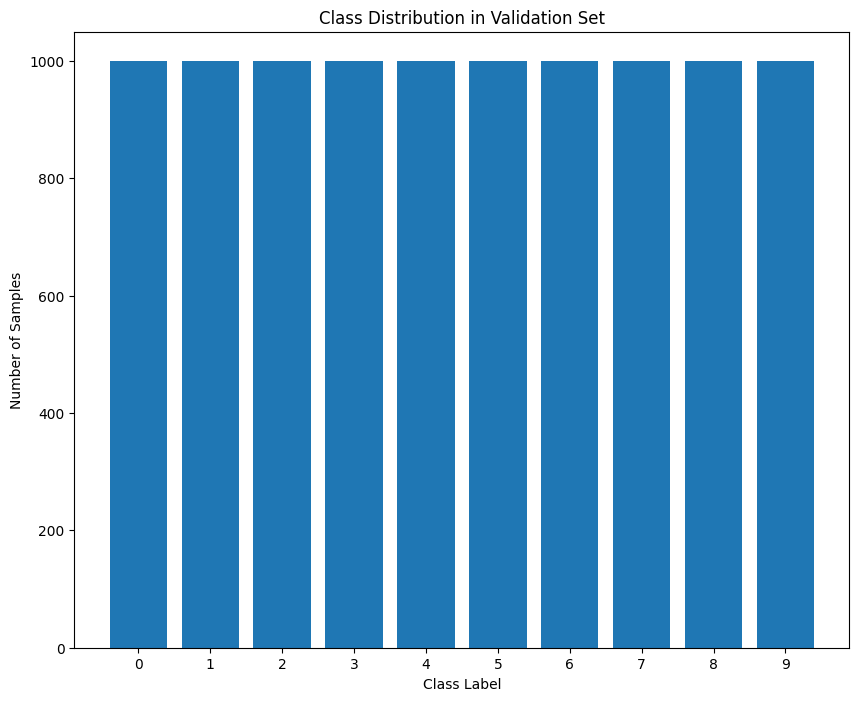

In [3]:
# Get true labels from validation dataset
y_true = np.concatenate([y for x, y in val_classifier_ds], axis=0)

# Plot class distribution
plt.figure(figsize=(10,8))
unique_labels, counts = np.unique(y_true, return_counts=True)
plt.bar(unique_labels, counts)
plt.title('Class Distribution in Validation Set')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(unique_labels)
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


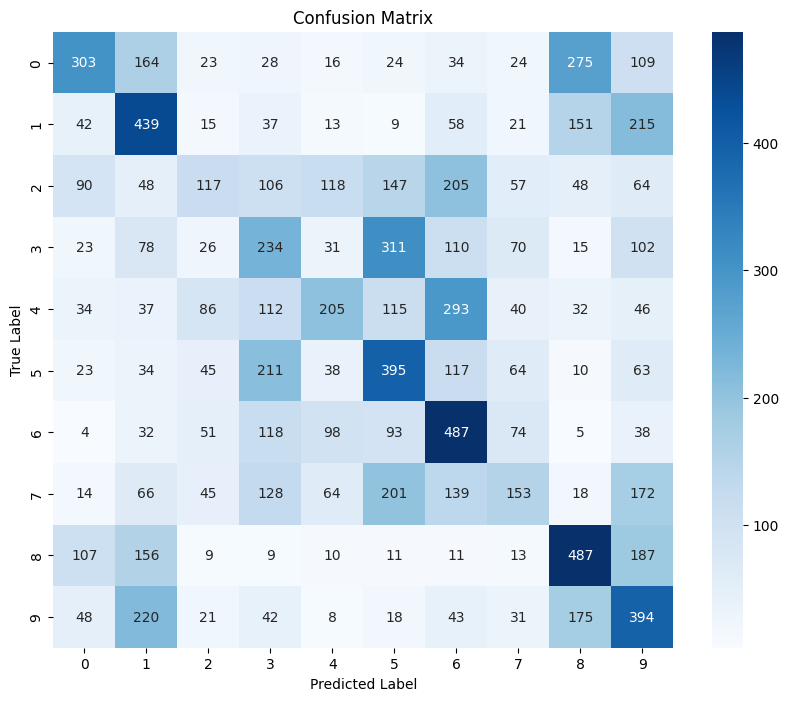

In [2]:
# Generate predictions and true labels
y_pred = classifier.predict(val_classifier_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in val_classifier_ds], axis=0)

# Create and plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Attempt 2

Epoch 1/10
Step 0: Contrastive Loss = 7.2123
Step 20: Contrastive Loss = 6.1900
Step 40: Contrastive Loss = 5.9948
Step 60: Contrastive Loss = 5.9140
Step 80: Contrastive Loss = 5.8788
Step 100: Contrastive Loss = 5.7730
Step 120: Contrastive Loss = 5.7418
Step 140: Contrastive Loss = 5.7021
Step 160: Contrastive Loss = 5.6411
Step 180: Contrastive Loss = 5.7001
Epoch 2/10
Step 0: Contrastive Loss = 5.6282
Step 20: Contrastive Loss = 5.6240
Step 40: Contrastive Loss = 5.5743
Step 60: Contrastive Loss = 5.6051
Step 80: Contrastive Loss = 5.5759
Step 100: Contrastive Loss = 5.5743
Step 120: Contrastive Loss = 5.5807
Step 140: Contrastive Loss = 5.5878
Step 160: Contrastive Loss = 5.5858
Step 180: Contrastive Loss = 5.5822
Epoch 3/10
Step 0: Contrastive Loss = 5.5930
Step 20: Contrastive Loss = 5.5773
Step 40: Contrastive Loss = 5.5679
Step 60: Contrastive Loss = 5.5539
Step 80: Contrastive Loss = 5.5779
Step 100: Contrastive Loss = 5.5626
Step 120: Contrastive Loss = 5.5495
Step 140: Con

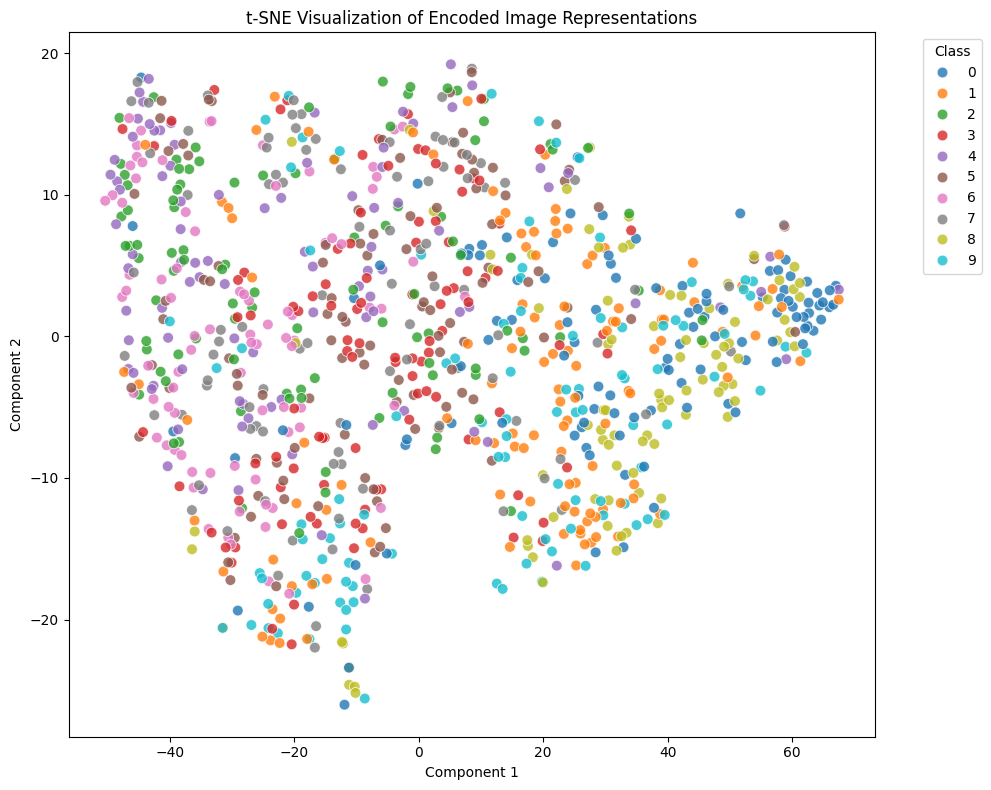

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2660 - loss: 2.0580 - val_accuracy: 0.3490 - val_loss: 1.7640
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3474 - loss: 1.7528 - val_accuracy: 0.3723 - val_loss: 1.6955
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3740 - loss: 1.6870 - val_accuracy: 0.3880 - val_loss: 1.6555
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3894 - loss: 1.6519 - val_accuracy: 0.3984 - val_loss: 1.6261
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4004 - loss: 1.6238 - val_accuracy: 0.4114 - val_loss: 1.6044


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# --- 1. Load and Preprocess Dataset ---
(train_ds, val_ds), ds_info = tfds.load('cifar10', split=['train', 'test'],
                                        as_supervised=True, with_info=True)

IMG_SIZE = 32
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

# --- 2. Data Augmentation for SimCLR ---
def simclr_augment(image):
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def simclr_preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return (simclr_augment(image), simclr_augment(image)), label

train_contrastive_ds = (train_ds
    .map(simclr_preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

# --- 3. Custom Encoder Model ---
def get_encoder():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.layers.Conv2D(64, 3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128)(x)
    return tf.keras.Model(inputs, x, name='encoder')

# --- 4. Projection Head ---
def add_projection_head(encoder):
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    features = encoder(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(features)
    outputs = tf.keras.layers.Dense(64)(x)
    return tf.keras.Model(inputs, outputs, name='simclr_model')

# --- 5. Contrastive Loss Function ---
def contrastive_loss(embeddings, temperature=0.5):
    embeddings = tf.math.l2_normalize(embeddings, axis=1)
    similarities = tf.matmul(embeddings, embeddings, transpose_b=True)
    batch_size = tf.shape(embeddings)[0] // 2
    labels = tf.range(batch_size)
    labels = tf.concat([labels, labels], axis=0)
    logits_mask = tf.linalg.set_diag(tf.ones_like(similarities), tf.zeros_like(tf.linalg.diag_part(similarities)))
    logits = similarities / temperature
    logits = logits * logits_mask
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return tf.reduce_mean(loss)

# --- 6. Training Step ---
encoder = get_encoder()
simclr_model = add_projection_head(encoder)
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x1, x2):
    with tf.GradientTape() as tape:
        z1 = simclr_model(x1, training=True)
        z2 = simclr_model(x2, training=True)
        embeddings = tf.concat([z1, z2], axis=0)
        loss = contrastive_loss(embeddings)
    gradients = tape.gradient(loss, simclr_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, simclr_model.trainable_variables))
    return loss

# --- 7. Training Loop ---
EPOCHS = 10
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for step, ((x1, x2), _) in enumerate(train_contrastive_ds):
        loss = train_step(x1, x2)
        if step % 20 == 0:
            print(f"Step {step}: Contrastive Loss = {loss.numpy():.4f}")

# --- 8. Visualize Embeddings with t-SNE ---
val_subset = val_ds.take(1000).map(preprocess).batch(1000)
images, labels = next(iter(val_subset))
embeddings = encoder(images, training=False).numpy()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels.numpy(), palette='tab10', s=60, alpha=0.8)
plt.title("t-SNE Visualization of Encoded Image Representations")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
# --- 9. Linear Evaluation ---
encoder.trainable = False

train_classifier_ds = (train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

val_classifier_ds = (val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

classifier = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Dense(256, activation='relu'),  # Added extra layer
    tf.keras.layers.Dense(10, activation='softmax')
])

classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.fit(train_classifier_ds, validation_data=val_classifier_ds, epochs=20)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2652 - loss: 2.0657 - val_accuracy: 0.3465 - val_loss: 1.7682
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3473 - loss: 1.7533 - val_accuracy: 0.3696 - val_loss: 1.6966
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3726 - loss: 1.6922 - val_accuracy: 0.3838 - val_loss: 1.6561
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3876 - loss: 1.6539 - val_accuracy: 0.3895 - val_loss: 1.6302
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3987 - loss: 1.6299 - val_accuracy: 0.4086 - val_loss: 1.6033
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4116 - loss: 1.6023 - val_accuracy: 0.4149 - val_loss: 1.5848
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4193 - loss: 1.5839 - val_accuracy: 0.4217 - val_loss: 1.5705
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4260 - loss: 1.5676 - val_accu

# Attempt 3

In [2]:
import sys
print(sys.executable)
!python --version

c:\Users\kflin\anaconda3\envs\py310\python.exe
Python 3.10.16


In [1]:
import tensorflow as tf
print("TF Version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TF Version: 2.10.1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Epoch 1/20
Step 0: Contrastive Loss = 6.7281
Step 10: Contrastive Loss = 6.0459
Step 20: Contrastive Loss = 5.9394
Step 30: Contrastive Loss = 5.8976
Step 40: Contrastive Loss = 5.8691
Step 50: Contrastive Loss = 5.7917
Step 60: Contrastive Loss = 5.7414
Step 70: Contrastive Loss = 5.7247
Step 80: Contrastive Loss = 5.7131
Step 90: Contrastive Loss = 5.7199
Step 100: Contrastive Loss = 5.6927
Step 110: Contrastive Loss = 5.6564
Step 120: Contrastive Loss = 5.6471
Step 130: Contrastive Loss = 5.6607
Step 140: Contrastive Loss = 5.6235
Step 150: Contrastive Loss = 5.6214
Step 160: Contrastive Loss = 5.6057
Step 170: Contrastive Loss = 5.6036
Step 180: Contrastive Loss = 5.6024
Step 190: Contrastive Loss = 5.6075
Epoch 2/20
Step 0: Contrastive Loss = 5.6218
Step 10: Contrastive Loss = 5.5868
Step 20: Contrastive Loss = 5.5869
Step 30: Contrastive Loss = 5.5703
Step 40: Contrastive Loss = 5.5843
Step 50: Contrastive Loss = 5.5623
Step 60: Contrastive Loss = 5.6024
Step 70: Contrastive Loss

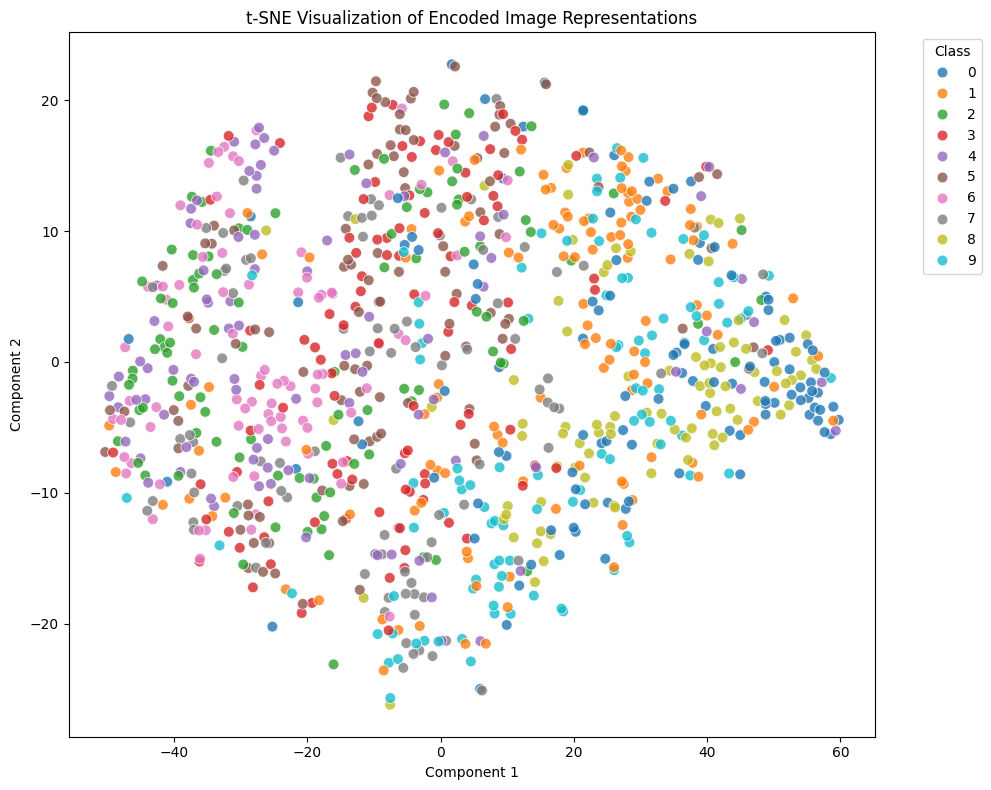

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

# --- 1. Load and Preprocess Dataset ---
(train_ds, val_ds), ds_info = tfds.load('cifar10', split=['train', 'test'],
                                        as_supervised=True, with_info=True)

IMG_SIZE = 32
BATCH_SIZE = 256  # Increased batch size for more negative samples
AUTOTUNE = tf.data.AUTOTUNE

# --- 2. Data Augmentation for SimCLR ---
def simclr_augment(image):
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 4, IMG_SIZE + 4)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, 0.5, 1.5)
    image = tf.image.adjust_saturation(image, np.random.uniform(0.5, 1.5))
    image = tf.image.adjust_hue(image, np.random.uniform(-0.2, 0.2))
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def simclr_preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return (simclr_augment(image), simclr_augment(image)), label

train_contrastive_ds = (train_ds
    .map(simclr_preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

# --- 3. Enhanced Encoder Model ---
def get_encoder():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128)(x)
    return tf.keras.Model(inputs, x, name='encoder')

# --- 4. Projection Head ---
def add_projection_head(encoder):
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    features = encoder(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(features)
    outputs = tf.keras.layers.Dense(64)(x)
    return tf.keras.Model(inputs, outputs, name='simclr_model')

# --- 5. Contrastive Loss Function ---
def contrastive_loss(embeddings, temperature=0.5):
    embeddings = tf.math.l2_normalize(embeddings, axis=1)
    similarities = tf.matmul(embeddings, embeddings, transpose_b=True)
    batch_size = tf.shape(embeddings)[0] // 2
    labels = tf.range(batch_size)
    labels = tf.concat([labels, labels], axis=0)
    logits_mask = tf.linalg.set_diag(tf.ones_like(similarities), tf.zeros_like(tf.linalg.diag_part(similarities)))
    logits = similarities / temperature
    logits = logits * logits_mask
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return tf.reduce_mean(loss)

# --- 6. Training Step ---
encoder = get_encoder()
simclr_model = add_projection_head(encoder)
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x1, x2):
    with tf.GradientTape() as tape:
        z1 = simclr_model(x1, training=True)
        z2 = simclr_model(x2, training=True)
        embeddings = tf.concat([z1, z2], axis=0)
        loss = contrastive_loss(embeddings)
    gradients = tape.gradient(loss, simclr_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, simclr_model.trainable_variables))
    return loss

# --- 7. Training Loop ---
EPOCHS = 20
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for step, ((x1, x2), _) in enumerate(train_contrastive_ds):
        loss = train_step(x1, x2)
        if step % 10 == 0:
            print(f"Step {step}: Contrastive Loss = {loss.numpy():.4f}")

# --- 8. Visualize Embeddings with t-SNE ---
val_subset = val_ds.take(1000).map(preprocess).batch(1000)
images, labels = next(iter(val_subset))
embeddings = encoder(images, training=False).numpy()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels.numpy(), palette='tab10', s=60, alpha=0.8)
plt.title("t-SNE Visualization of Encoded Image Representations")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
# --- 9. Linear Evaluation ---
encoder.trainable = False

train_classifier_ds = (train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(10000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

val_classifier_ds = (val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

classifier = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classifier.fit(train_classifier_ds, validation_data=val_classifier_ds, epochs=20)


Epoch 1/20
196/196 [==============================] - 3s 12ms/step - loss: 1.6214 - accuracy: 0.4115 - val_loss: 1.5206 - val_accuracy: 0.4494
Epoch 2/20
196/196 [==============================] - 2s 11ms/step - loss: 1.4934 - accuracy: 0.4586 - val_loss: 1.4760 - val_accuracy: 0.4639
Epoch 3/20
196/196 [==============================] - 2s 11ms/step - loss: 1.4472 - accuracy: 0.4770 - val_loss: 1.4414 - val_accuracy: 0.4719
Epoch 4/20
196/196 [==============================] - 2s 11ms/step - loss: 1.4151 - accuracy: 0.4870 - val_loss: 1.4237 - val_accuracy: 0.4811
Epoch 5/20
196/196 [==============================] - 2s 11ms/step - loss: 1.3852 - accuracy: 0.5001 - val_loss: 1.4124 - val_accuracy: 0.4902
Epoch 6/20
196/196 [==============================] - 2s 11ms/step - loss: 1.3660 - accuracy: 0.5064 - val_loss: 1.4140 - val_accuracy: 0.4887
Epoch 7/20
196/196 [==============================] - 2s 11ms/step - loss: 1.3501 - accuracy: 0.5122 - val_loss: 1.3899 - val_accuracy: 0.5009